<a href="https://colab.research.google.com/github/auroramugnai/ArXivClassification/blob/main/ArXivClassification/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone the github repository and move to the inner directory.

In [1]:
!git clone https://github.com/auroramugnai/ArXivClassification.git
%cd ArXivClassification/ArXivClassification

Cloning into 'ArXivClassification'...
remote: Enumerating objects: 1637, done.
remote: Counting objects: 100% (275/275), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 1637 (delta 240), reused 197 (delta 196), pack-reused 1362
Receiving objects: 100% (1637/1637), 18.60 MiB | 23.90 MiB/s, done.
Resolving deltas: 100% (856/856), done.
/content/ArXivClassification/ArXivClassification


# 1) Build the dataset

In [2]:
import json
import os
import random
import zipfile

import dask.bag as db
import matplotlib.pyplot as plt
import pandas as pd

from utils import text_cleaner

In [3]:
SEED = 42 # fix random seed for reproducibility

## 1.1 Download the dataset
The following line of code comes from clicking on "Copy API command" in https://www.kaggle.com/datasets/Cornell-University/arxiv.

In [4]:
!kaggle datasets download -d Cornell-University/arxiv

Dataset URL: https://www.kaggle.com/datasets/Cornell-University/arxiv
License(s): CC0-1.0
100% 1.28G/1.28G [00:12<00:00, 69.8MB/s]
100% 1.28G/1.28G [00:12<00:00, 106MB/s] 


Unzip the downloaded file.

In [5]:
with zipfile.ZipFile('./arxiv.zip', 'r') as zip_ref:
    zip_ref.extractall()

The unzipping creates an "arxiv-metadata-oai-snapshot.json". We now create a dask bag out of it.

In [48]:
path = "./arxiv-metadata-oai-snapshot.json"
arxiv_data = db.read_text(path).map(json.loads)
arxiv_data.take(1)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

## 1.2 Get rid of some unnecessary information

In [79]:
# Get the latest version of the articles.
get_latest_version = lambda x: x['versions'][-1]['created']

# Only keep articles published after 2022.
is_after_2022 = lambda x: int(get_latest_version(x).split(' ')[3]) > 2022

# Only keep articles that have at most 3 categories.
has_categs = lambda x: len(x['categories'].split(' ')) in {1,2,3}

# Only keep some information.
cut_info = lambda x: {'id': x['id'],
                      'title': x['title'],
                      'category':x['categories'].split(' '),
                      'abstract':x['abstract'],}

arxiv_data_filtered = (arxiv_data.filter(is_after_2022).filter(has_categs).map(cut_info).compute())

# Create a pandas dataframe and save it to csv.
df = pd.DataFrame(arxiv_data_filtered)
# df.to_csv("./arxiv_data_filtered.csv", index=False)
df.head()

,id,title,category,abstract
0,0706.0190,Quantum Properties and Gravitational Field of ...,[physics.gen-ph],We find that a field with oscillations of ma...
1,0707.0434,Another generalization of Mason's ABC-theorem,[math.NT],We show a generalization of Mason's ABC-theo...
2,0707.3421,The nature of electromagnetic energy,[physics.gen-ph],The nature of electromagnetic energy for gen...
3,0707.4544,Orbital period derivative of a binary system u...,[physics.gen-ph],It is proposed that the equations of motion ...
4,0708.2658,"On positive opetopes, positive opetopic cardin...",[math.GT],We introduce the notion of a positive opetop...


## 1.3 Get a fixed number of articles
To speed up computation and avoid a session crash.

In [80]:
num_data = 20000 # number of articles that we want to keep
print(f"The dataset contains {len(df)} articles.")

# Sample the dataset only if its length exceeds num_data.
if(len(df) > num_data):
    n_sample = num_data
    random.seed(SEED)
    df = df.sample(n=n_sample, axis=0)

print(f"The dataset contains {len(df)} articles.")

The dataset contains 150290 articles.
The dataset contains 20000 articles.


# 2) Text processing

In [51]:
!pip install -U spacy -q
!python -m spacy download en_core_web_md -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 13.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [52]:
import en_core_web_md
import spacy
from tqdm import tqdm

In [81]:
# Remove stop words, punctuation, special characters, numbers.
nlp = spacy.load("en_core_web_md")
tqdm.pandas() # to display progress bar

# First on abstracts.
clean_abs = lambda x: text_cleaner(text=x["abstract"], nlp=nlp)
df["clean_abstract"] = df.progress_apply(clean_abs, axis=1)

# Then on titles.
clean_tit = lambda x: text_cleaner(text=x["title"], nlp=nlp)
df["clean_title"] = df.progress_apply(clean_tit, axis=1)

df.tail()

100%|██████████| 20000/20000 [03:12<00:00, 104.03it/s]


,id,title,category,abstract,clean_abstract,clean_title
117153,2401.05289,On a fixed point formula of Navarro-Rizo,[math.GR],Let G be a pi-separable group with a Hall pi...,let g pi separable group hall pi subgroup h or...,fix point formula navarro rizo
124247,2402.03376,Weighted Conformal LiDAR-Mapping for Structure...,[cs.RO],One of the main challenges in simultaneous l...,main challenge simultaneous localization mappi...,weighted conformal lidar mapping structured slam
8907,2204.03997,High-accuracy Hamiltonian learning via delocal...,[quant-ph],Learning the unknown Hamiltonian governing t...,learn unknown hamiltonian govern dynamic quant...,high accuracy hamiltonian learning delocalized...
101784,2311.07490,A Guide to Evaluating the Experience of Media ...,[cs.HC],Evaluation is essential to understanding the...,evaluation essential understand value digital ...,guide evaluate experience media arts technology
15925,2210.00248,Heterogeneous Graph Contrastive Multi-view Lea...,[cs.LG],Inspired by the success of contrastive learn...,inspire success contrastive learning cl comput...,heterogeneous graph contrastive multi view lea...


In [82]:
# Add a space to separate title and abstract.
df["clean_title"] = df["clean_title"].astype(str) + " "
df["text"] = df["clean_title"] + df["clean_abstract"]

# Save to csv.
# df.to_csv(f"./processed_dataframe.csv", index=False)
df.head()

,id,title,category,abstract,clean_abstract,clean_title,text
82306,2309.01489,Moment-Based Estimation of Diffusion and Adopt...,[econ.EM],"According to standard econometric theory, Ma...",accord standard econometric theory maximum lik...,moment base estimation diffusion adoption para...,moment base estimation diffusion adoption para...
5123,2109.05998,Options Pricing under Bayesian MS-VAR Process,[q-fin.MF],"In this paper, we have studied option pricin...",paper study option pricing method base bayesia...,option pricing bayesian ms var process,option pricing bayesian ms var process paper s...
76816,2308.06218,Splittings of One-Ended Groups with One-Ended ...,[math.GR],We introduce the notion of halfspaces associ...,introduce notion halfspaces associate group sp...,splitting ended groups ended halfspaces acycli...,splitting ended groups ended halfspaces acycli...
144446,2404.08548,Qubit frugal entanglement determination with t...,[quant-ph],We study the deep multi-scale entanglement r...,study deep multi scale entanglement renormaliz...,qubit frugal entanglement determination deep m...,qubit frugal entanglement determination deep m...
134636,2403.07449,Single-Switch Transformer-less Power Supply fo...,[physics.plasm-ph],"This work presents a simple power converter,...",work present simple power converter high volta...,single switch transformer power supply low tem...,single switch transformer power supply low tem...


# 3) Vectorization

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [84]:
# Convert the texts into a TF-IDF matrix.
text = df["text"].values
vectorizer = TfidfVectorizer(max_features=2**12, stop_words='english')

X = vectorizer.fit_transform(text)

# 4) Dimensionality reduction with PCA

In [85]:
from sklearn.decomposition import PCA

In [86]:
# Reduce the dimensionality of the data to 3.
n_components = 3
pca = PCA(n_components=n_components, random_state=SEED)
tqdm.pandas()
X_reduced = pca.fit_transform(X.toarray())
X_reduced.shape

(20000, 3)

# 5) Find the number of clusters with K-Means

In [59]:
!pip install kneed -q

In [60]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from kneed import KneeLocator

<Figure size 640x480 with 0 Axes>

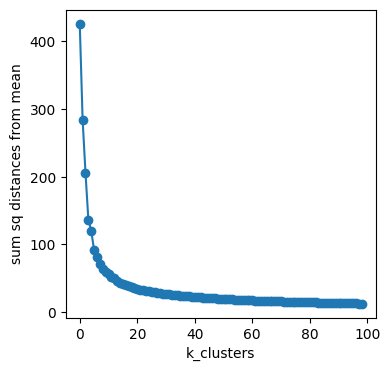

In [87]:
# Perform the cluster algorithm k_max times and calculate the ssd from mean.
cluster_errors = []

k_max = 100
for i in range(1, k_max):
    n_clusters = i
    pipe_pca_kmean = Pipeline([("cluster", KMeans(n_init='auto',
                                                  n_clusters=n_clusters,
                                                  random_state=SEED,
                                                  verbose=0)
                                )])

    pipe_pca_kmean.fit(X_reduced)
    pipe_pca_kmean.predict(X_reduced)
    cluster_errors.append(pipe_pca_kmean.named_steps["cluster"].inertia_)

# Plot the sum squared distances from mean.
plt.clf()
plt.figure(figsize=(4,4))
plt.plot(cluster_errors, "o-")
plt.xlabel("k_clusters")
plt.ylabel("sum sq distances from mean")
plt.show()

In [88]:
# Find the optimal value of k with KneeLocator.
kl = KneeLocator(range(1, k_max), cluster_errors, curve="convex",
                 direction="decreasing")

# 6) Predict the clusters on our dataset

In [97]:
k_optimal = kl.elbow
import numpy as np
# k_optimal = len(np.unique(df['category']))

print('k_optimal = ', k_optimal)

k_optimal =  12


In [64]:
from sklearn.cluster import KMeans

In [98]:
# Predict the clusters.
kmeans = KMeans(n_clusters=k_optimal, random_state=SEED, n_init='auto')
y_pred = kmeans.fit_predict(X_reduced)

## Calculate clustering metrics

In [66]:
from sklearn.metrics import silhouette_score, davies_bouldin_score,\
                            calinski_harabasz_score

In [99]:
# Calculate clustering metrics.
silhouette = silhouette_score(X_reduced, kmeans.labels_)
db_index = davies_bouldin_score(X_reduced, kmeans.labels_)
ch_index = calinski_harabasz_score(X_reduced, kmeans.labels_)

# Print the metric scores.
print(f"Silhouette Score: {silhouette:.2f}")
print(f"Davies-Bouldin Index: {db_index:.2f}")
print(f"Calinski-Harabasz Index: {ch_index:.2f}")

Silhouette Score: 0.33
Davies-Bouldin Index: 0.95
Calinski-Harabasz Index: 13312.69


In [102]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

# km = KMeans(n_clusters=k_optimal,
#             init='k-means++',
#             n_init=5,
#             max_iter=300)
# y_km = km.fit_predict(X_reduced)

# cluster_labels = np.unique(y_km)
# n_clusters = cluster_labels.shape[0]
# silhouette_vals = silhouette_samples(X_reduced, y_km, metric='euclidean')
# y_ax_lower, y_ax_upper = 0, 0
# yticks = []
# for i, c in enumerate(cluster_labels):
#     c_silhouette_vals = silhouette_vals[y_km == c]
#     c_silhouette_vals.sort()
#     y_ax_upper += len(c_silhouette_vals)
#     color = cm.jet(i / n_clusters)
#     plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
#              edgecolor='none', color=color)

#     yticks.append((y_ax_lower + y_ax_upper) / 2.)
#     y_ax_lower += len(c_silhouette_vals)

# silhouette_avg = np.mean(silhouette_vals)
# plt.axvline(silhouette_avg, color="red", linestyle="--")

# plt.yticks(yticks, cluster_labels + 1)
# plt.ylabel('Cluster')
# plt.xlabel('Silhouette coefficient')
# plt.tight_layout()
# plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 12 The average silhouette_score is : 0.32116337456189675


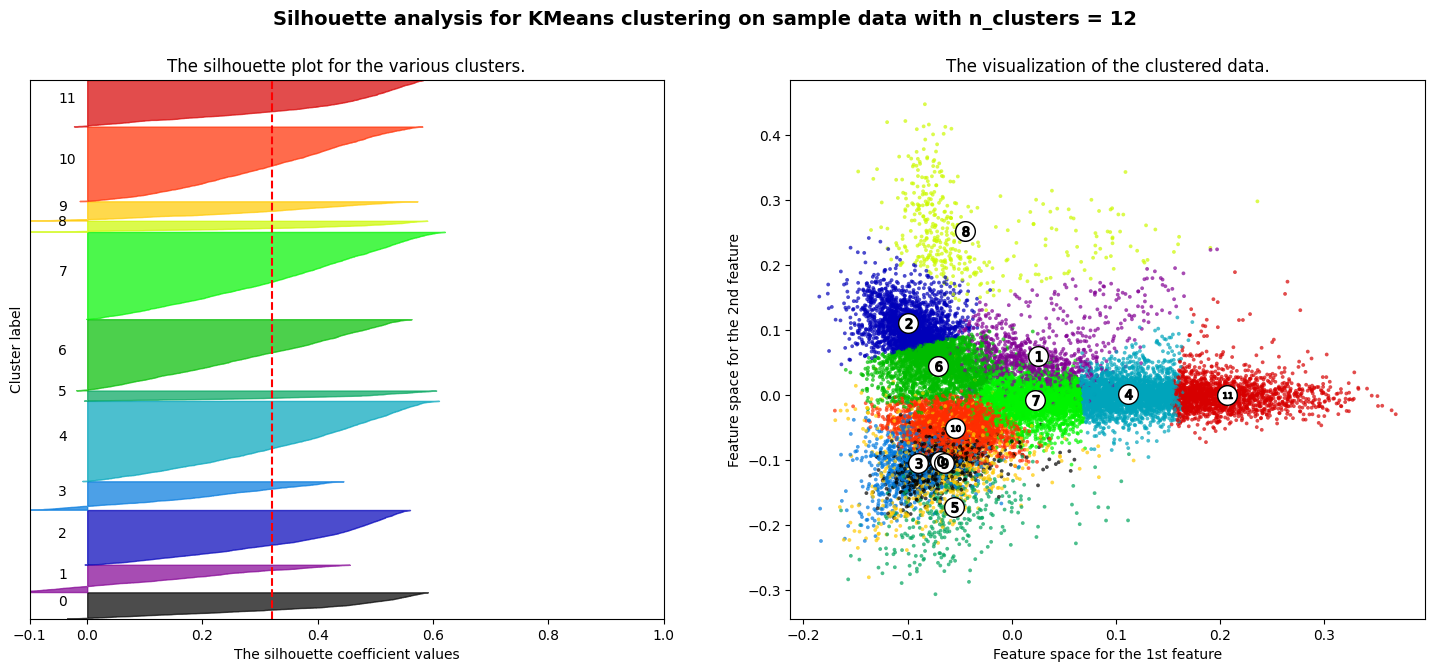

In [105]:
n_clusters = k_optimal

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]

ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X_reduced) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
clusterer = KMeans(n_clusters=n_clusters, random_state=SEED)
cluster_labels = clusterer.fit_predict(X_reduced)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
silhouette_avg = silhouette_score(X_reduced, cluster_labels)
print(
"For n_clusters =",
n_clusters,
"The average silhouette_score is :",
silhouette_avg,
)

    # Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_reduced, cluster_labels)

y_lower = 10
for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(
X_reduced[:, 0], X_reduced[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

# 7) Plot the clusters with UMAP


In [68]:
!pip install umap-learn -q

In [69]:
import plotly.express as px
from umap import UMAP

In [101]:
# UMAP definition.
umap_embeddings = UMAP(min_dist=0.1, n_components=n_components)
X_umap = umap_embeddings.fit_transform(X_reduced)


# Plot.
x, y, z = list(zip(*X_umap))
fig = px.scatter_3d(df, x, y, z, color=y_pred.astype(str),
                    color_discrete_sequence=px.colors.qualitative.Dark24,
                    hover_data=['category', 'title'])
fig.update_traces(marker_size=3)
fig.show()